In [1]:
%matplotlib inline
import os, pickle, logging, pickle, joblib, sys, warnings
warnings.simplefilter('ignore')
from scipy import stats
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import catboost as cb

from sklearn import ensemble, metrics, pipeline, preprocessing, impute, model_selection
from scipy.stats import pearsonr, spearmanr

import shap

font_path = "/home/zhoujb/local/font/Times New Roman.ttf"
mpl.font_manager.fontManager.addfont(font_path)
prop = mpl.font_manager.FontProperties(fname=font_path)
mpl.rcParams['font.family'] = prop.get_name()
mpl.rcParams['font.sans-serif'] = ["Times New Roman"]
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams['pdf.fonttype'] = 42

RAW_PATH = "/data2/zhoujb/project/cowpea_project/rawData/"
ML_RAW_PATH = "/data2/zhoujb/project/cowpea_project/basedXPXLR/ML/rawData/"
FS_PATH = "/data2/zhoujb/project/cowpea_project/basedXPXLR/ML/fs_PSugar/"
TEST_RES_PATH = "/data2/zhoujb/project/cowpea_project/basedXPXLR/ML/tesRes/"
FIG_PATH = "/data2/zhoujb/project/cowpea_project/basedXPXLR/ML/figRes/"

In [2]:
feat_col_raw = []
with open(os.path.join(FS_PATH, "cb_rfa_cv_psugar_rmse")) as f:
    for line in f:
        feat_col_raw.append(line.strip())

feat_col = []
feat_col_map = {}
for item in feat_col_raw:
    feat_col.append(item[4:])
    feat_col_map[item] = item[4:]


raw_data = pd.read_table(os.path.join(ML_RAW_PATH, "raw_data_PSugar.txt"), sep="\t", index_col=0)
raw_data = raw_data.rename(columns=feat_col_map)

target_col = ['HZ-PSugar']
raw_data = raw_data.dropna(subset=target_col)

kf = model_selection.KFold(n_splits=5, shuffle=True,  random_state=0)
y_test_final, y_pred_final = [], []
for i, (train_index, test_index) in enumerate(kf.split(raw_data)):
    data_train = raw_data.iloc[train_index].copy()
    data_test = raw_data.iloc[test_index].copy()

    scale_tool = preprocessing.StandardScaler()
    scale_tool.fit(data_train.loc[:, feat_col])
    data_train.loc[:, feat_col] = scale_tool.transform(data_train.loc[:, feat_col])
    data_test.loc[:, feat_col] = scale_tool.transform(data_test.loc[:, feat_col])

    train_sel = data_train.sample(frac=0.8, random_state=0)
    val_sel = data_train.drop(train_sel.index).copy()

    X_train = train_sel[feat_col].copy()
    y_train = train_sel[target_col].values.ravel()

    X_val = val_sel[feat_col].copy()
    y_val = val_sel[target_col].values.ravel()

    X_test = data_test[feat_col].copy()
    y_test = data_test[target_col].values.ravel()

    if i == 2:
        break

# Initialize CatBoostClassifier
clf_model = cb.CatBoostRegressor(random_state=0, thread_count=4, loss_function='RMSE')
# Fit model
clf_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=0, plot=False)

y_pred = clf_model.predict(X_test)

#score_pear = pearsonr(y_test, y_pred)[0]
score_spear = spearmanr(y_test, y_pred)[0]
score_rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)
score_nrmse = score_rmse / np.std(y_test)

score_spear, score_rmse, score_nrmse

(0.7595998888580163, 1.37179549693909, 0.6414949635339829)

In [3]:
data_scale = raw_data[feat_col].copy()
data_scale.loc[:, feat_col] = scale_tool.transform(data_scale.loc[:, feat_col])

explainer = shap.TreeExplainer(clf_model)
shap_values = explainer(data_scale[feat_col])

In [4]:
detail_info = pd.read_excel(os.path.join(RAW_PATH, "Detail_information_344.xlsx"), index_col="Genotype No.")
detail_info = detail_info.loc[data_scale.index]
detail_info["Type"] = detail_info["Types"].map({'Grain':"G", 'V-landrace':"VL", '-':"NA", 'V-cultivar':"VC"})

Source = detail_info.loc[data_scale.index]["Type"].to_list()

target_df = raw_data[target_col]
target_df = pd.concat([target_df, detail_info[["Type"]]], axis=1)
target_df = target_df.reset_index()

In [5]:
target_df[target_df["index"]=="D554"]

,index,HZ-PSugar,Type
249,D554,15.028264,VL


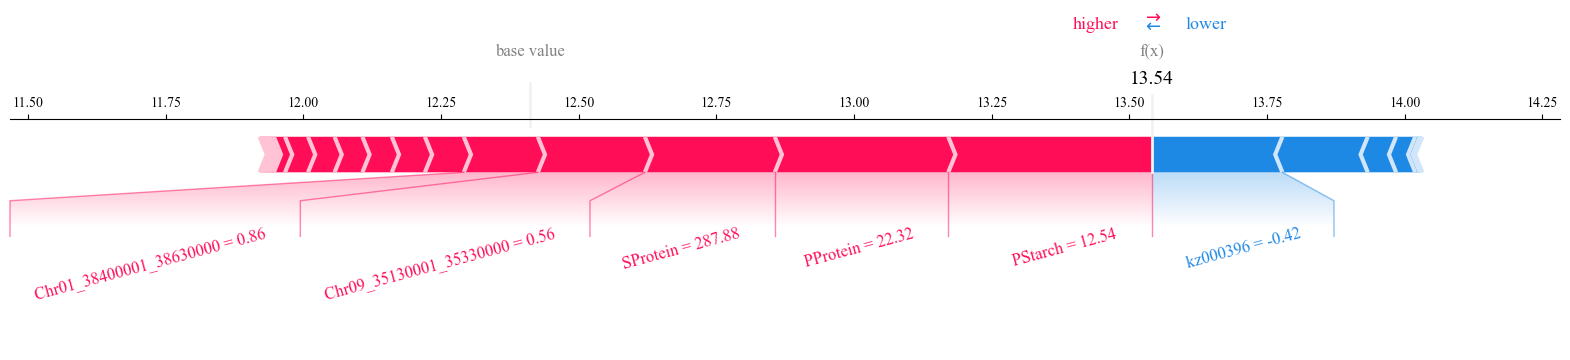

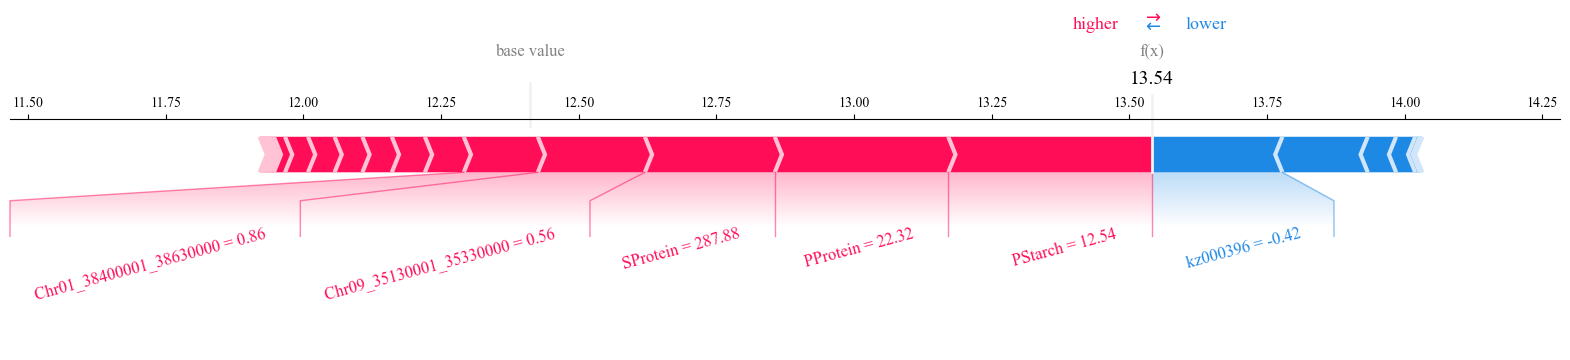

In [10]:
need_plot_num, need_plot_name = 249, "D554"

with plt.rc_context():
    shap.force_plot(explainer.expected_value,
                    shap_values[:, feat_col].values[need_plot_num],
                    raw_data[feat_col].round(2).loc[need_plot_name, feat_col].values,
                    feat_col,text_rotation=15,
                    matplotlib=True, show = True)
    #plt.savefig(os.path.join(FIG_PATH, "fig_6_{}_force_plot.pdf".format(need_plot_name)),  format="pdf", dpi=1000, bbox_inches="tight", transparent=True)

In [6]:
target_df[target_df["Type"]=="G"].sort_values(by="HZ-PSugar")

,index,HZ-PSugar,Type
286,D667,6.697756,G
94,D642,8.087721,G
76,D605,8.117652,G
188,D380,8.190065,G
214,D538,8.224567,G
61,D621,8.280064,G
38,D392,8.296805,G
229,D622,8.550689,G
23,D608,8.582762,G
57,D598,8.634156,G


In [15]:
need_plot_num, need_plot_name = 76, "D605"

with plt.rc_context():
    shap.force_plot(explainer.expected_value,
                    shap_values[:, feat_col].values[need_plot_num],
                    raw_data[feat_col].round(2).loc[need_plot_name, feat_col].values,
                    feat_col,text_rotation=15,
                    matplotlib=True, show = False)
    plt.savefig(os.path.join(FIG_PATH, "fig_6_{}_force_plot.pdf".format(need_plot_name)),  format="pdf", dpi=1000, bbox_inches="tight")

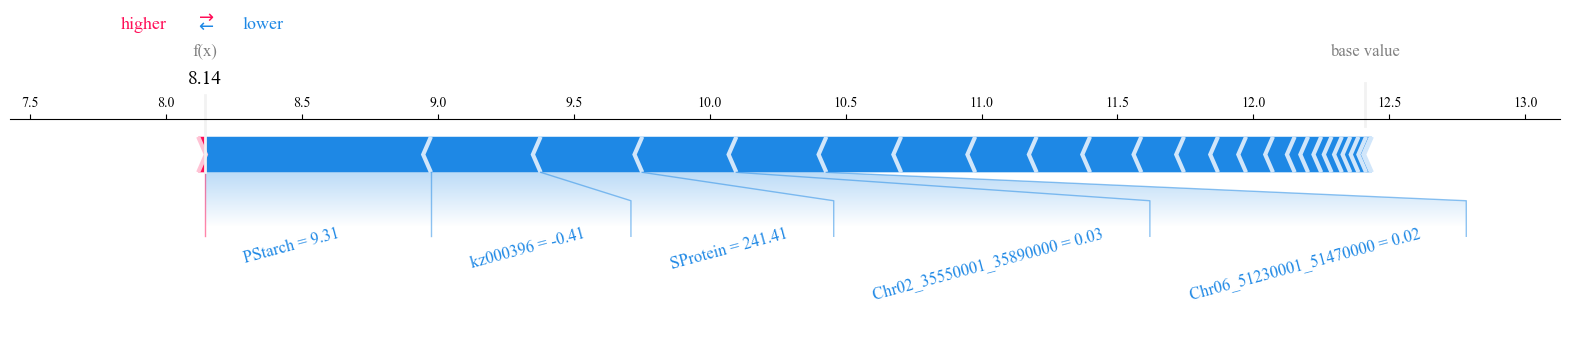

In [8]:
need_plot_num, need_plot_name = 94, "D642"

with plt.rc_context():
    shap.force_plot(explainer.expected_value,
                    shap_values[:, feat_col].values[need_plot_num],
                    raw_data[feat_col].round(2).loc[need_plot_name, feat_col].values,
                    feat_col,text_rotation=15,
                    matplotlib=True, show = True)
    #plt.savefig(os.path.join(FIG_PATH, "fig_4a_young_disease_1.pdf"),  format="pdf", dpi=1000, bbox_inches="tight")

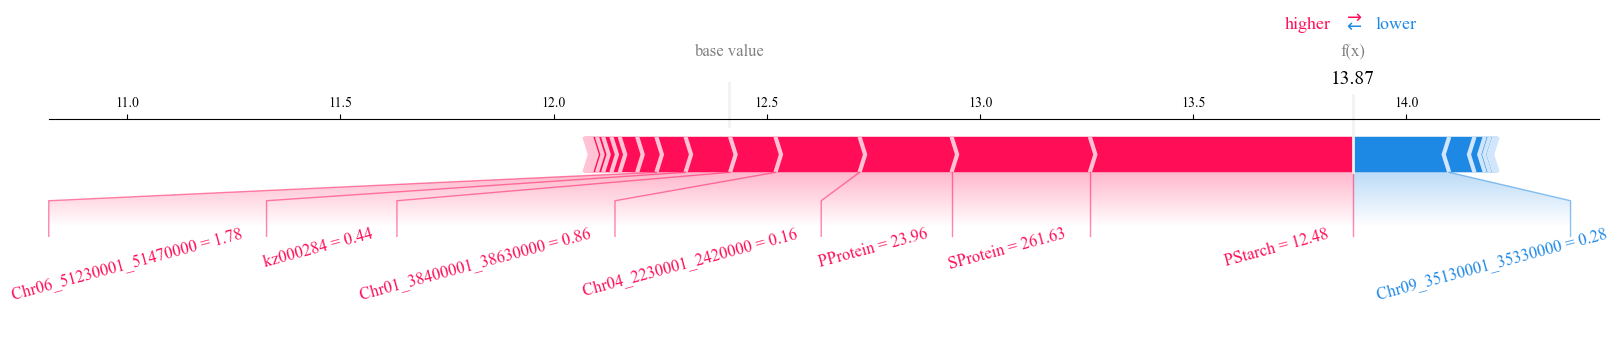

In [10]:
need_plot_num, need_plot_name = 267, "D589"

with plt.rc_context():
    shap.force_plot(explainer.expected_value,
                    shap_values[:, feat_col].values[need_plot_num],
                    raw_data[feat_col].round(2).loc[need_plot_name, feat_col].values,
                    feat_col,text_rotation=15,
                    matplotlib=True, show = True)
    #plt.savefig(os.path.join(FIG_PATH, "fig_4a_young_disease_1.pdf"),  format="pdf", dpi=1000, bbox_inches="tight")

In [11]:
target_df[target_df["Type"]=="VL"].sort_values(by="HZ-PSugar")

,index,HZ-PSugar,Type
13,D442,7.461347,VL
83,D599,7.691432,VL
144,D404,8.666861,VL
226,D619,9.160117,VL
44,D578,9.337161,VL
...,...,...,...
280,D550,16.641254,VL
87,D504,16.748584,VL
240,D522,17.339600,VL
208,D571,17.894059,VL


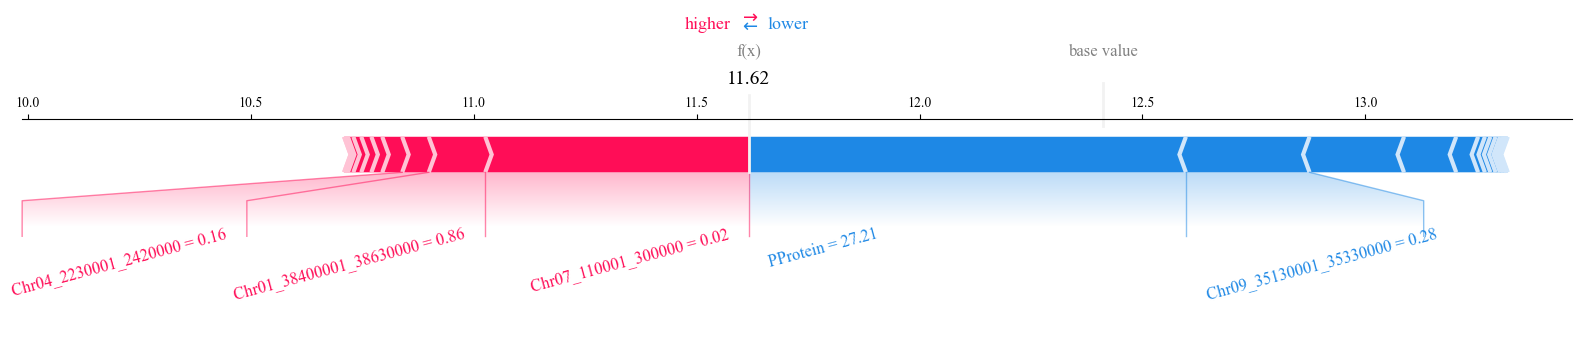

In [12]:
need_plot_num, need_plot_name = 13, "D442"

with plt.rc_context():
    shap.force_plot(explainer.expected_value,
                    shap_values[:, feat_col].values[need_plot_num],
                    raw_data[feat_col].round(2).loc[need_plot_name, feat_col].values,
                    feat_col,text_rotation=15,
                    matplotlib=True, show = True)
    #plt.savefig(os.path.join(FIG_PATH, "fig_4a_young_disease_1.pdf"),  format="pdf", dpi=1000, bbox_inches="tight")

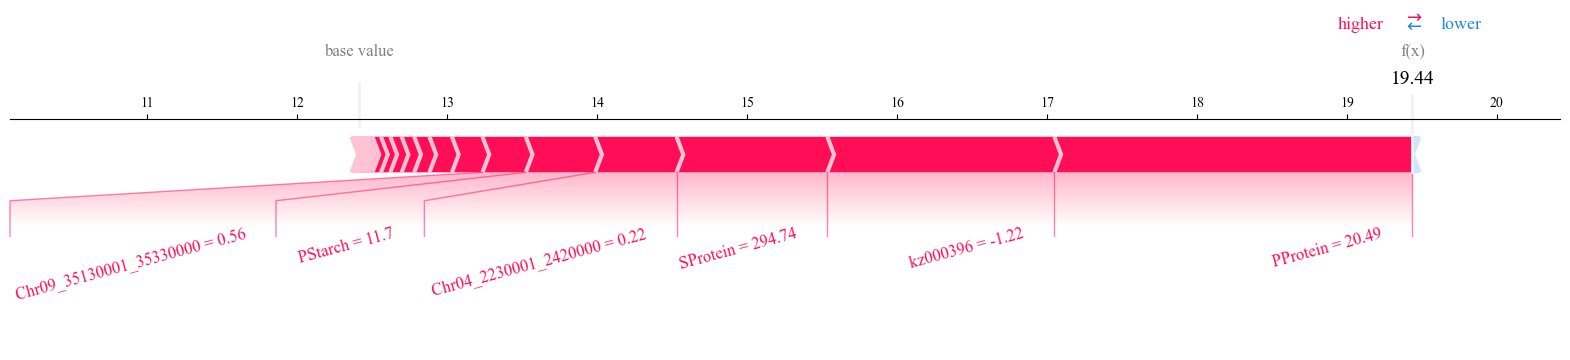

In [13]:
need_plot_num, need_plot_name = 205, "D395"

with plt.rc_context():
    shap.force_plot(explainer.expected_value,
                    shap_values[:, feat_col].values[need_plot_num],
                    raw_data[feat_col].round(2).loc[need_plot_name, feat_col].values,
                    feat_col,text_rotation=15,
                    matplotlib=True, show = True)
    #plt.savefig(os.path.join(FIG_PATH, "fig_4a_young_disease_1.pdf"),  format="pdf", dpi=1000, bbox_inches="tight")

In [16]:
need_plot_num, need_plot_name = 208, "D571"

with plt.rc_context():
    shap.force_plot(explainer.expected_value,
                    shap_values[:, feat_col].values[need_plot_num],
                    raw_data[feat_col].round(2).loc[need_plot_name, feat_col].values,
                    feat_col,text_rotation=15,
                    matplotlib=True, show = False)
    plt.savefig(os.path.join(FIG_PATH, "fig_6_{}_force_plot.pdf".format(need_plot_name)),  format="pdf", dpi=1000, bbox_inches="tight")